<a href="https://colab.research.google.com/github/FatimeNazliAs/Image-Segmentation-with-Oxford-IIIT-Pet-Dataset/blob/main/oxford_image_seg_get_data_manually.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('//content//drive//')

Mounted at //content//drive//


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from glob import glob
from PIL import Image
import random



In [ ]:
def cleanAndStore(path):
  image_list = sorted(os.listdir(path + 'images'))
  mask_list = sorted(os.listdir(path  + 'annotations/trimaps'))

  new_image = []
  new_mask = []

  for imaj in image_list:

    mock = cv2.imread(path + 'images/' + imaj, cv2.IMREAD_COLOR)

    try:
      mock = cv2.resize(mock, (128, 128), interpolation=cv2.INTER_AREA)
    except:
      continue
      

    imaj = imaj[0:-3]

    for maske in mask_list:

      maske = maske[0:-3]


      if imaj == maske:
        new_image.append(imaj + 'jpg')
        new_mask.append(maske + 'png')
        mask_list.pop(0)
        break

  return new_image, new_mask
path = '/content/drive/MyDrive/annotation/'
im, ma = cleanAndStore(path)
print(len(ma))
print(len(im))

7384
7384


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def collect(images,mask, low, high):

    image_list = []
    mask_list = []

    a = low
    print(images)
    for filename in images:
        a += 1
        
        image = cv2.imread(path + 'images/' + filename, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (128, 128))
        image = tf.cast(image, tf.float32) / 255.0

        image_list.append(image)
    

        if a == high:
            break

    a = low
    for filename in mask:
        a += 1
        mask = cv2.imread(path + 'annotations/trimaps/' + filename, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (128, 128))
        mask -= 1
        mask_list.append(mask)

        if a == high:
            break




    return image_list, mask_list


In [ ]:
x,y = collect(im,ma,0,6000)
z,t = collect(im,ma,6001,7501)

['Abyssinian_1.jpg', 'Abyssinian_10.jpg', 'Abyssinian_100.jpg', 'Abyssinian_101.jpg', 'Abyssinian_102.jpg', 'Abyssinian_103.jpg', 'Abyssinian_104.jpg', 'Abyssinian_105.jpg', 'Abyssinian_106.jpg', 'Abyssinian_107.jpg', 'Abyssinian_108.jpg', 'Abyssinian_109.jpg', 'Abyssinian_11.jpg', 'Abyssinian_110.jpg', 'Abyssinian_111.jpg', 'Abyssinian_112.jpg', 'Abyssinian_113.jpg', 'Abyssinian_114.jpg', 'Abyssinian_115.jpg', 'Abyssinian_116.jpg', 'Abyssinian_117.jpg', 'Abyssinian_118.jpg', 'Abyssinian_119.jpg', 'Abyssinian_12.jpg', 'Abyssinian_120.jpg', 'Abyssinian_121.jpg', 'Abyssinian_122.jpg', 'Abyssinian_123.jpg', 'Abyssinian_124.jpg', 'Abyssinian_125.jpg', 'Abyssinian_126.jpg', 'Abyssinian_127.jpg', 'Abyssinian_128.jpg', 'Abyssinian_129.jpg', 'Abyssinian_13.jpg', 'Abyssinian_130.jpg', 'Abyssinian_131.jpg', 'Abyssinian_132.jpg', 'Abyssinian_133.jpg', 'Abyssinian_134.jpg', 'Abyssinian_135.jpg', 'Abyssinian_136.jpg', 'Abyssinian_137.jpg', 'Abyssinian_138.jpg', 'Abyssinian_139.jpg', 'Abyssinian_14.

In [ ]:
def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))

    dataset = dataset.batch(batch,drop_remainder=True)

    dataset = dataset.prefetch(10)

    return dataset 

train_dataset = tf_dataset(x,y)

test_dataset = tf_dataset(z,t)



<function show at 0x7fed4ae837a0>


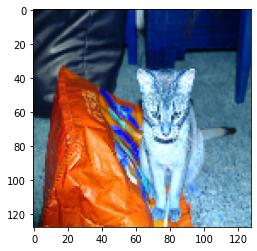

In [ ]:
plt.imshow(x[7])
print(plt.show)


<function show at 0x7fed4ae837a0>


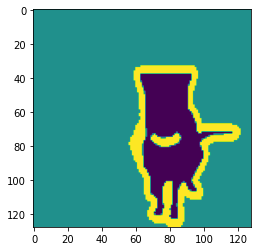

In [ ]:
plt.imshow(y[7])
print(plt.show)

In [ ]:
BATCH_SIZE = 4
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).repeat()


In [ ]:

def double_conv_block(x,n_filters):
  x=layers.Conv2D(n_filters,3,padding="same",activation="relu",kernel_initializer="he_normal")(x)
  x=layers.Conv2D(n_filters,3,padding="same",activation="relu",kernel_initializer="he_normal")(x)
  
  return x
  

def downsample_block(x,n_filters):
    f=double_conv_block(x,n_filters)
    p=layers.MaxPool2D(2)(f)
    p=layers.Dropout(0.3)(p)
    return f,p


def upsample_block(x,conv_features,n_filters):
  x=layers.Conv2DTranspose(n_filters,3,2,padding="same")(x)
  x=layers.concatenate([x,conv_features])
  x=layers.Dropout(0.3)(x)
  x=double_conv_block(x,n_filters)
  return x






In [ ]:
def build_unet_model():
  inputs=layers.Input(shape=(128,128,3))
  # encoder: contracting path - downsample
  f1,p1=downsample_block(inputs,64)
  f2,p2=downsample_block(p1,128)
  f3,p3=downsample_block(p2,256)
  f4,p4=downsample_block(p3,512)

  

  bottleneck=double_conv_block(p4,1024)

  # decoder: expanding path - upsample
  u6=upsample_block(bottleneck,f4,512)
  u7=upsample_block(u6,f3,256)
  u8=upsample_block(u7,f2,128)
  u9=upsample_block(u8,f1,64)

  outputs=layers.Conv2D(3,1,padding="same",activation = "softmax")(u9)

  unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
  return unet_model

checkpoint_path = "/content/drive/MyDrive/training_7"
checkpoint_dir = os.path.dirname(checkpoint_path)
#Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=100*BATCH_SIZE)

unet_model = build_unet_model()
# Save the weights using the `checkpoint_path` format
unet_model.save_weights(checkpoint_path.format(epoch=0))
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# unet_model.load_weights(latest)
# unet_model.summary()


unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'] )
                

NUM_EPOCHS = 10
TRAIN_LENGTH = 2000

STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5

TEST_LENGTH = 400

VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=60,
                              callbacks=[cp_callback],
                              validation_steps=20,
                           
                              validation_data=test_dataset)

Epoch 1/10
55/60 [==========================>...] - ETA: 18s - loss: 0.9928 - accuracy: 0.5516

KeyboardInterrupt: ignored

In [ ]:
for a in range(100,105):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.axis(False)
    plt.title("Original Image", fontweight="bold")
    
    plt.imshow(x[a])

    plt.subplot(1,2,2)
    plt.axis(False)
    plt.title("Segmentation Mask", fontweight="bold")
    img = np.expand_dims(x[a],axis=0)
    plt.imshow(unet_model.predict(img)[0,:,:,:])

In [ ]:
print(os.listdir(checkpoint_dir))
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)

loss = model_history .history['loss']
print(loss)
val_loss = model_history .history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = model_history .history['accuracy']
val_acc = model_history .history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()